
# Exploración de Dataset


Descargar el dataset **NASA Bearings** https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset. 


# Importar librerías

Importar aquellas librerías que serán utilizadas en el trabajo.

In [154]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import math

from cmath import sqrt
from fileinput import filename
import os
from os.path import isfile, join
from matplotlib.pyplot import axis
from numpy import divide

# Cargar datos
Cargar los datos de entrenamiento.

In [244]:
from math import floor

PATH_DATASET = "./dataset02.csv"
PATH_CSV_REDUCED = 'dataset02-RED.csv'
rodamiento_que_fallo = 1    # Del 1 al 4


cols_per_bearing = 14   # Number of single_features per bearing
single_features = {'aMean': 0, 'std': 1, 'irq': 2, 'skew': 3, 'kurtosis': 4, 'f0': 5, 'Pf0': 6, 'Xrms': 7, 'zeroX': 8, 'p2p': 9, 'crest': 10, 'clearance': 11, 'shape': 12, 'impulse': 13}    # List of features computed for single bearings

df = pd.read_csv(PATH_DATASET)

# Es importante reconocer que, por cómo está formado el experimento, la variable objetivo del dataset solo cuenta con un 1 (falló el rodamiento) al final del experimento. Esto resulta un problema 
# para entrenar cualquier tipo de modelo debido a la baja cantidad de samples positivas que va a tener el dataset final que se use para entrenar. 
# Por otro lado, aunque se logre entrenar un modelo que logre predecir con cierta confiabilidad que un rodamiento falló, al tener el 1 solo al final el modelo tendería a reconocer una falla crítica del rodamiento
# es decir, cuando este dejó de funcionar, lo que en un ambiente productivo implicaría una parada de la máquina para hacer un cambio del rodamiento. Esto va en contra de lo que se quiere lograr con el mantenimiento 
# preventivo, donde se busca predecir la falla antes de que ocurra, incluso aunque esto implique cambiar el rodamiento antes de tiempo. 
# Por éstas razones, se propone aumentar la cantidad de unos (1) en el dataset para que el modelo aprenda las condiciones cercanas al punto final de falla y las identifique cómo una falla y así se notifique para
# hacer mantenimiento de ese rodamiento. EL criterio para la cantidad de unos a agregar al final del dataset se toma de forma arbitraria ya que se desconoce la criticidad de la máquina donde se quiere hacer el 
# mantenimiento preventivo, pero este valor se podría aumentar o disminuir según sea necesario para preveer con mayor o menor tiempo de anticipación la falla de un rodamiento.
# En nuestro caso, se busca que el modelo intente predecir una falla dentro de las 24 horas previas a la falla final del rodamiento. Ya que las mediciones se hacen cada 10 minutos, esto equivale a poner en 1 las últimas
# 288 filas (24 x 60 min / 10 min).

horas_de_prediccion = 24
minutos_entre_muestras = 10

filas = floor(horas_de_prediccion * 60 / minutos_entre_muestras)
print('Se setearán las últimas ' + str(filas) + ' filas en 1.')
idx=0
target = 'y'+str(rodamiento_que_fallo-1)
for i in range(len(df)):
    idx+=1
    if idx>(len(df)-filas):
        df.iloc[i][target]=1

Se setearán las últimas 144 filas en 1.


In [245]:
df.describe()

,aMean_0,std_0,irq_0,skew_0,kurtosis_0,f0_0,Pf0_0,Xrms_0,zeroX_0,p2p_0,...,covar_01,covar_02,covar_03,covar_12,covar_13,covar_23,y0,y1,y2,y3
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,9.840000e+02,9.840000e+02,984.000000,984.0,984.0,984.0
mean,0.080905,0.106090,0.128091,-0.033123,0.827138,1488.989853,52.411202,0.106111,6879.347561,1.054736,...,0.001577,-0.000474,-0.000045,-0.001310,-1.368870e-03,7.654559e-04,0.146341,0.0,0.0,0.0
std,0.040171,0.058233,0.058001,0.089029,0.965787,1202.293360,2.529818,0.058224,442.081350,0.740102,...,0.001227,0.000621,0.001092,0.002179,1.020015e-03,1.083733e-03,0.353628,0.0,0.0,0.0
min,0.001168,0.000987,0.000000,-0.766067,-1.609774,58.593750,15.223287,0.001533,0.000000,0.005000,...,-0.016802,-0.006265,-0.003449,-0.017709,-9.969288e-03,5.918902e-07,0.000000,0.0,0.0,0.0
25%,0.060764,0.077110,0.100000,-0.047506,0.393747,985.351562,51.522408,0.077137,6649.750000,0.752000,...,0.001407,-0.000580,-0.000314,-0.001028,-1.180721e-03,3.675887e-04,0.000000,0.0,0.0,0.0
50%,0.062005,0.078747,0.103000,-0.009859,0.484787,985.351562,52.352332,0.078778,6759.500000,0.830000,...,0.001508,-0.000503,-0.000262,-0.000590,-1.048524e-03,4.074848e-04,0.000000,0.0,0.0,0.0
75%,0.083222,0.108789,0.131000,0.013705,0.878688,985.351562,52.871842,0.108819,7161.000000,1.101750,...,0.001630,-0.000414,-0.000092,-0.000482,-9.966261e-04,5.216813e-04,0.000000,0.0,0.0,0.0
max,0.453318,0.725014,0.630000,0.579698,14.110009,4849.609375,65.182241,0.725001,8870.000000,9.998000,...,0.010003,0.010375,0.019175,0.000025,6.124187e-07,8.906680e-03,1.000000,0.0,0.0,0.0


### Exploracion del dataset

In [246]:
print(df.columns)

Index(['aMean_0', 'std_0', 'irq_0', 'skew_0', 'kurtosis_0', 'f0_0', 'Pf0_0',
       'Xrms_0', 'zeroX_0', 'p2p_0', 'crest_0', 'clearance_0', 'shape_0',
       'impulse_0', 'aMean_1', 'std_1', 'irq_1', 'skew_1', 'kurtosis_1',
       'f0_1', 'Pf0_1', 'Xrms_1', 'zeroX_1', 'p2p_1', 'crest_1', 'clearance_1',
       'shape_1', 'impulse_1', 'aMean_2', 'std_2', 'irq_2', 'skew_2',
       'kurtosis_2', 'f0_2', 'Pf0_2', 'Xrms_2', 'zeroX_2', 'p2p_2', 'crest_2',
       'clearance_2', 'shape_2', 'impulse_2', 'aMean_3', 'std_3', 'irq_3',
       'skew_3', 'kurtosis_3', 'f0_3', 'Pf0_3', 'Xrms_3', 'zeroX_3', 'p2p_3',
       'crest_3', 'clearance_3', 'shape_3', 'impulse_3', 'covar_01',
       'covar_02', 'covar_03', 'covar_12', 'covar_13', 'covar_23', 'y0', 'y1',
       'y2', 'y3'],
      dtype='object')


<AxesSubplot:ylabel='crest_0'>

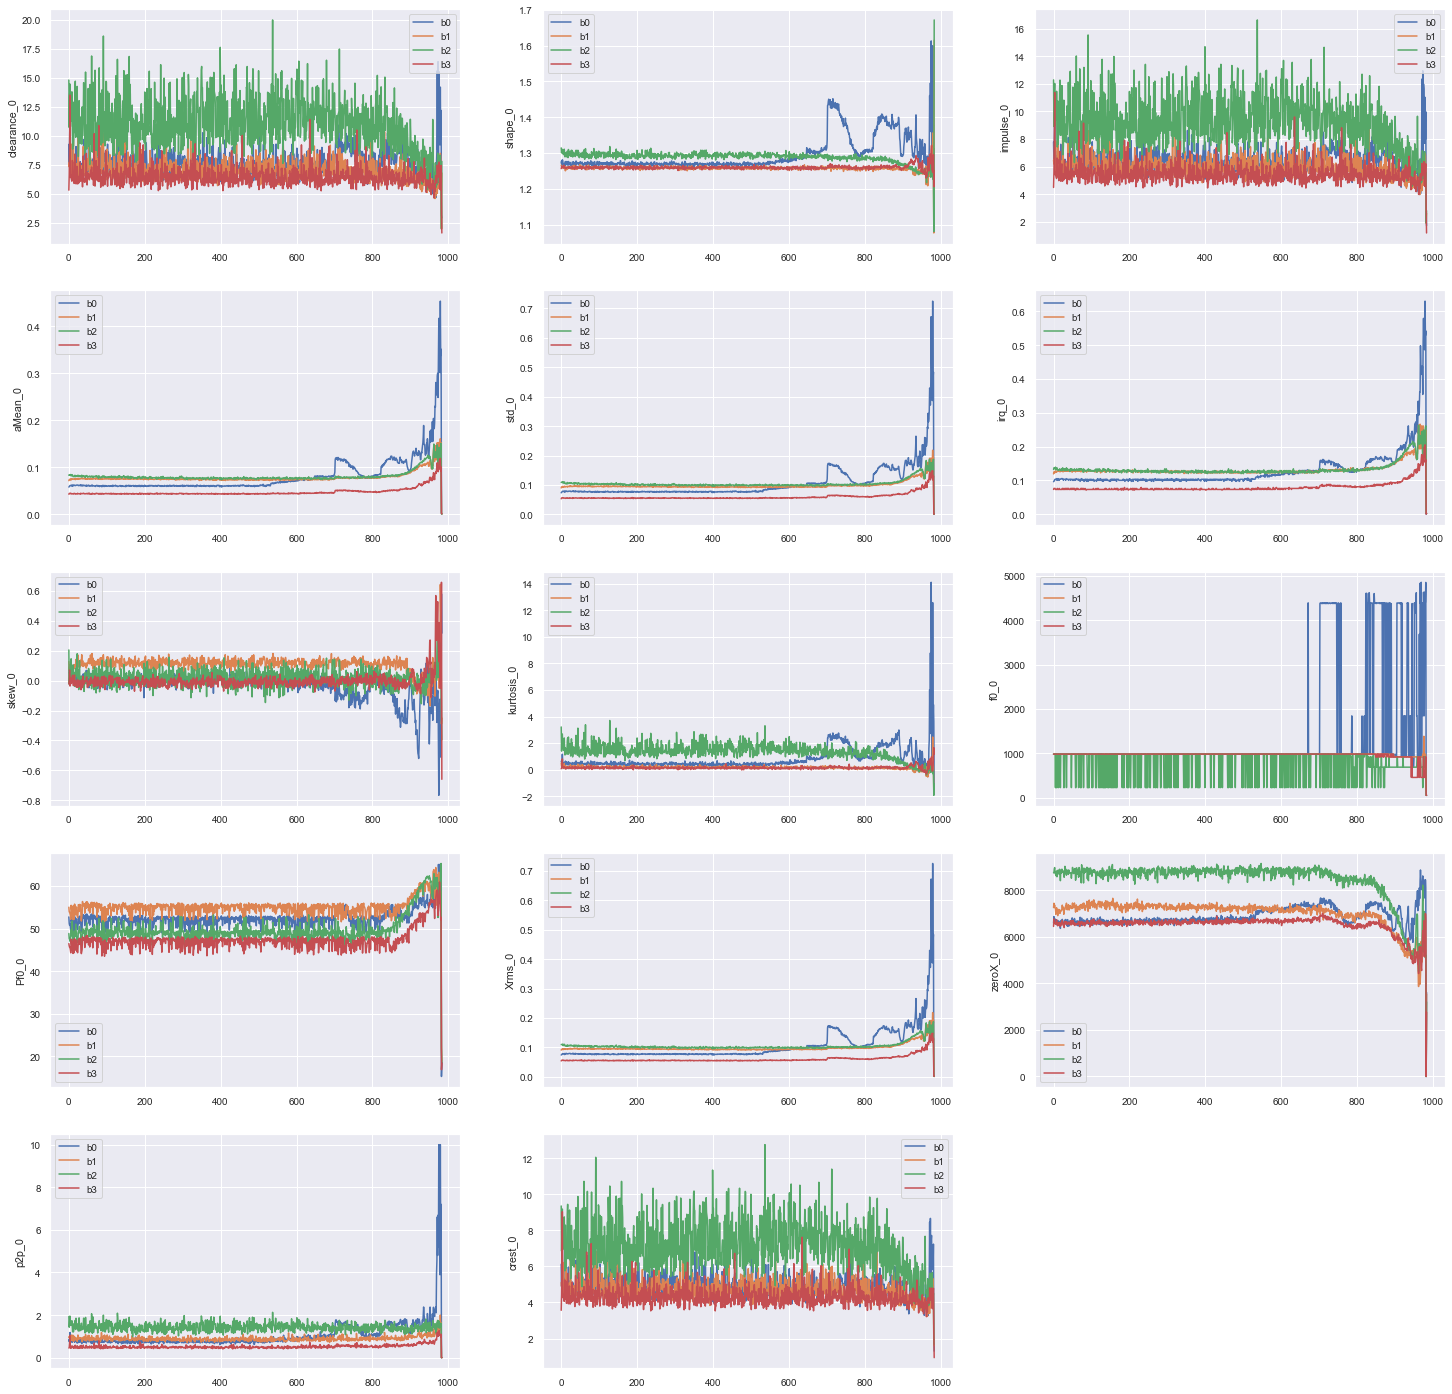

In [247]:
from matplotlib.pyplot import ylabel

plt.figure(figsize=(25,25))
plt.subplot(5,3,1)
sns.lineplot(x=df.index, y=df['clearance_0'], label='b0')
sns.lineplot(x=df.index, y=df['clearance_1'], label='b1')
sns.lineplot(x=df.index, y=df['clearance_2'], label='b2')
sns.lineplot(x=df.index, y=df['clearance_3'], label='b3')

plt.subplot(5,3,2)
sns.lineplot(x=df.index, y=df['shape_0'], label='b0')
sns.lineplot(x=df.index, y=df['shape_1'], label='b1')
sns.lineplot(x=df.index, y=df['shape_2'], label='b2')
sns.lineplot(x=df.index, y=df['shape_3'], label='b3')

plt.subplot(5,3,3)
sns.lineplot(x=df.index, y=df['impulse_0'], label='b0')
sns.lineplot(x=df.index, y=df['impulse_1'], label='b1')
sns.lineplot(x=df.index, y=df['impulse_2'], label='b2')
sns.lineplot(x=df.index, y=df['impulse_3'], label='b3')

plt.subplot(5,3,4)
sns.lineplot(x=df.index, y=df['aMean_0'], label='b0')
sns.lineplot(x=df.index, y=df['aMean_1'], label='b1')
sns.lineplot(x=df.index, y=df['aMean_2'], label='b2')
sns.lineplot(x=df.index, y=df['aMean_3'], label='b3')

plt.subplot(5,3,5)
sns.lineplot(x=df.index, y=df['std_0'], label='b0')
sns.lineplot(x=df.index, y=df['std_1'], label='b1')
sns.lineplot(x=df.index, y=df['std_2'], label='b2')
sns.lineplot(x=df.index, y=df['std_3'], label='b3')

plt.subplot(5,3,6)
sns.lineplot(x=df.index, y=df['irq_0'], label='b0')
sns.lineplot(x=df.index, y=df['irq_1'], label='b1')
sns.lineplot(x=df.index, y=df['irq_2'], label='b2')
sns.lineplot(x=df.index, y=df['irq_3'], label='b3')

plt.subplot(5,3,7)
sns.lineplot(x=df.index, y=df['skew_0'], label='b0')
sns.lineplot(x=df.index, y=df['skew_1'], label='b1')
sns.lineplot(x=df.index, y=df['skew_2'], label='b2')
sns.lineplot(x=df.index, y=df['skew_3'], label='b3')

plt.subplot(5,3,8)
sns.lineplot(x=df.index, y=df['kurtosis_0'], label='b0')
sns.lineplot(x=df.index, y=df['kurtosis_1'], label='b1')
sns.lineplot(x=df.index, y=df['kurtosis_2'], label='b2')
sns.lineplot(x=df.index, y=df['kurtosis_3'], label='b3')

plt.subplot(5,3,9)
sns.lineplot(x=df.index, y=df['f0_0'], label='b0')
sns.lineplot(x=df.index, y=df['f0_1'], label='b1')
sns.lineplot(x=df.index, y=df['f0_2'], label='b2')
sns.lineplot(x=df.index, y=df['f0_3'], label='b3')
       
plt.subplot(5,3,10)
sns.lineplot(x=df.index, y=df['Pf0_0'], label='b0')
sns.lineplot(x=df.index, y=df['Pf0_1'], label='b1')
sns.lineplot(x=df.index, y=df['Pf0_2'], label='b2')
sns.lineplot(x=df.index, y=df['Pf0_3'], label='b3')

plt.subplot(5,3,11)
sns.lineplot(x=df.index, y=df['Xrms_0'], label='b0')
sns.lineplot(x=df.index, y=df['Xrms_1'], label='b1')
sns.lineplot(x=df.index, y=df['Xrms_2'], label='b2')
sns.lineplot(x=df.index, y=df['Xrms_3'], label='b3')

plt.subplot(5,3,12)
sns.lineplot(x=df.index, y=df['zeroX_0'], label='b0')
sns.lineplot(x=df.index, y=df['zeroX_1'], label='b1')
sns.lineplot(x=df.index, y=df['zeroX_2'], label='b2')
sns.lineplot(x=df.index, y=df['zeroX_3'], label='b3')

plt.subplot(5,3,13)
sns.lineplot(x=df.index, y=df['p2p_0'], label='b0')
sns.lineplot(x=df.index, y=df['p2p_1'], label='b1')
sns.lineplot(x=df.index, y=df['p2p_2'], label='b2')
sns.lineplot(x=df.index, y=df['p2p_3'], label='b3')

plt.subplot(5,3,14)
sns.lineplot(x=df.index, y=df['crest_0'], label='b0')
sns.lineplot(x=df.index, y=df['crest_1'], label='b1')
sns.lineplot(x=df.index, y=df['crest_2'], label='b2')
sns.lineplot(x=df.index, y=df['crest_3'], label='b3')

In [248]:
# df.hist(figsize=(25,25), bins=25)

### Selección de features

#### Normalidad de los features

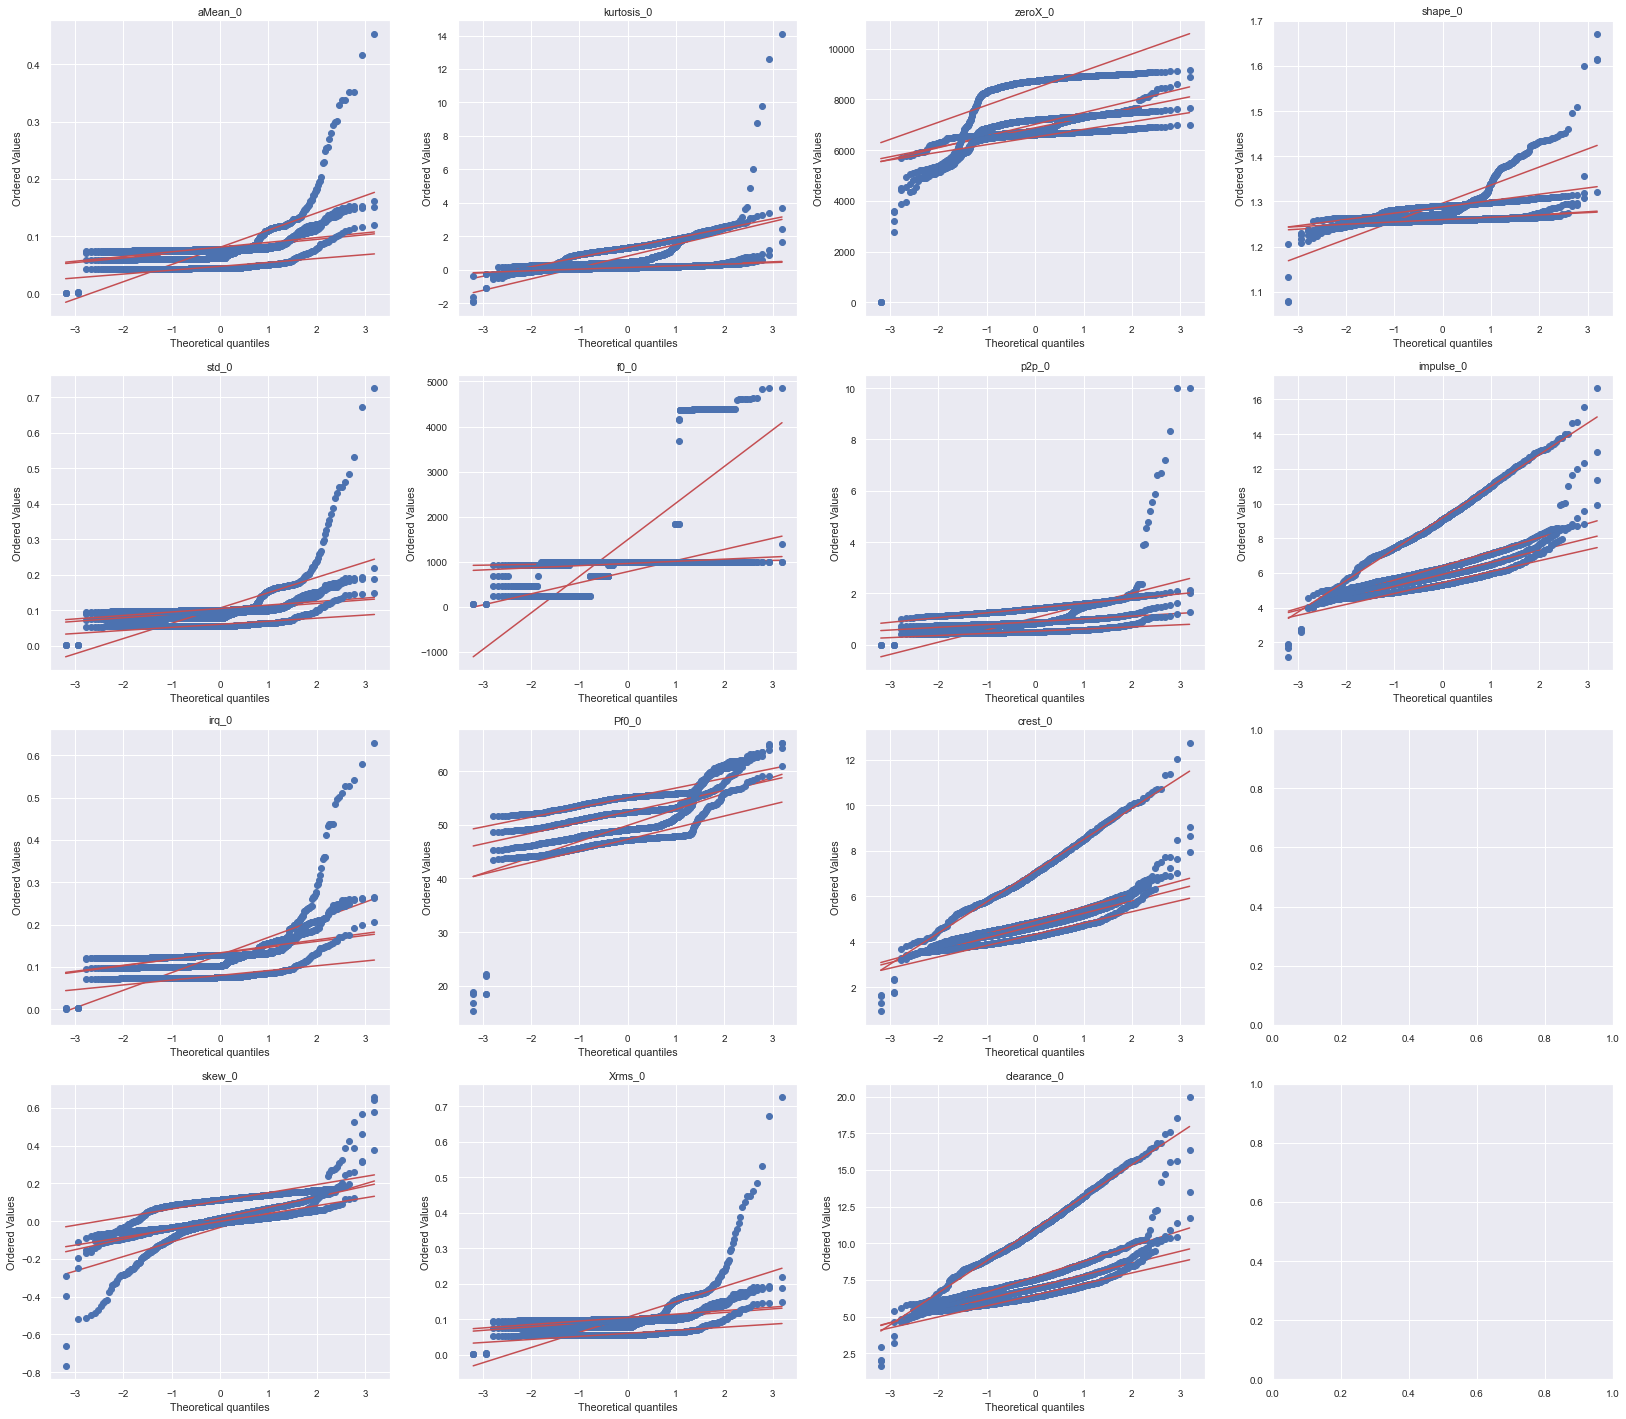

In [249]:
from scipy import stats
# Check conditions for using Pearson
plots_rows = 4
fig, axis = plt.subplots(plots_rows,4,figsize=(28,25)) 
for i in range(4):  # for each bearing
    col_offset = i * cols_per_bearing
    for k, xi in enumerate(np.array(df.iloc[:,col_offset:col_offset+cols_per_bearing]).T):
        if(k >= cols_per_bearing):
            break
        stats.probplot(xi, dist="norm", plot=axis[k%plots_rows,k//plots_rows])
        axis[k%plots_rows,k//plots_rows].set_title(df.columns.values[k])

# A partir de los gráficos, se puede ver que algunos features siguen distribuciones "casi" normales: p2p, crest, clearance, impulse
# Esta normalidad se mantiene para los 4 rodamientos a lo largo de todo el experimento, salvo en los momentos cercanos a la falla, 
# donde se puede ver una divergencia respecto a la distribución normal. 

#### Pearson vs Spearman

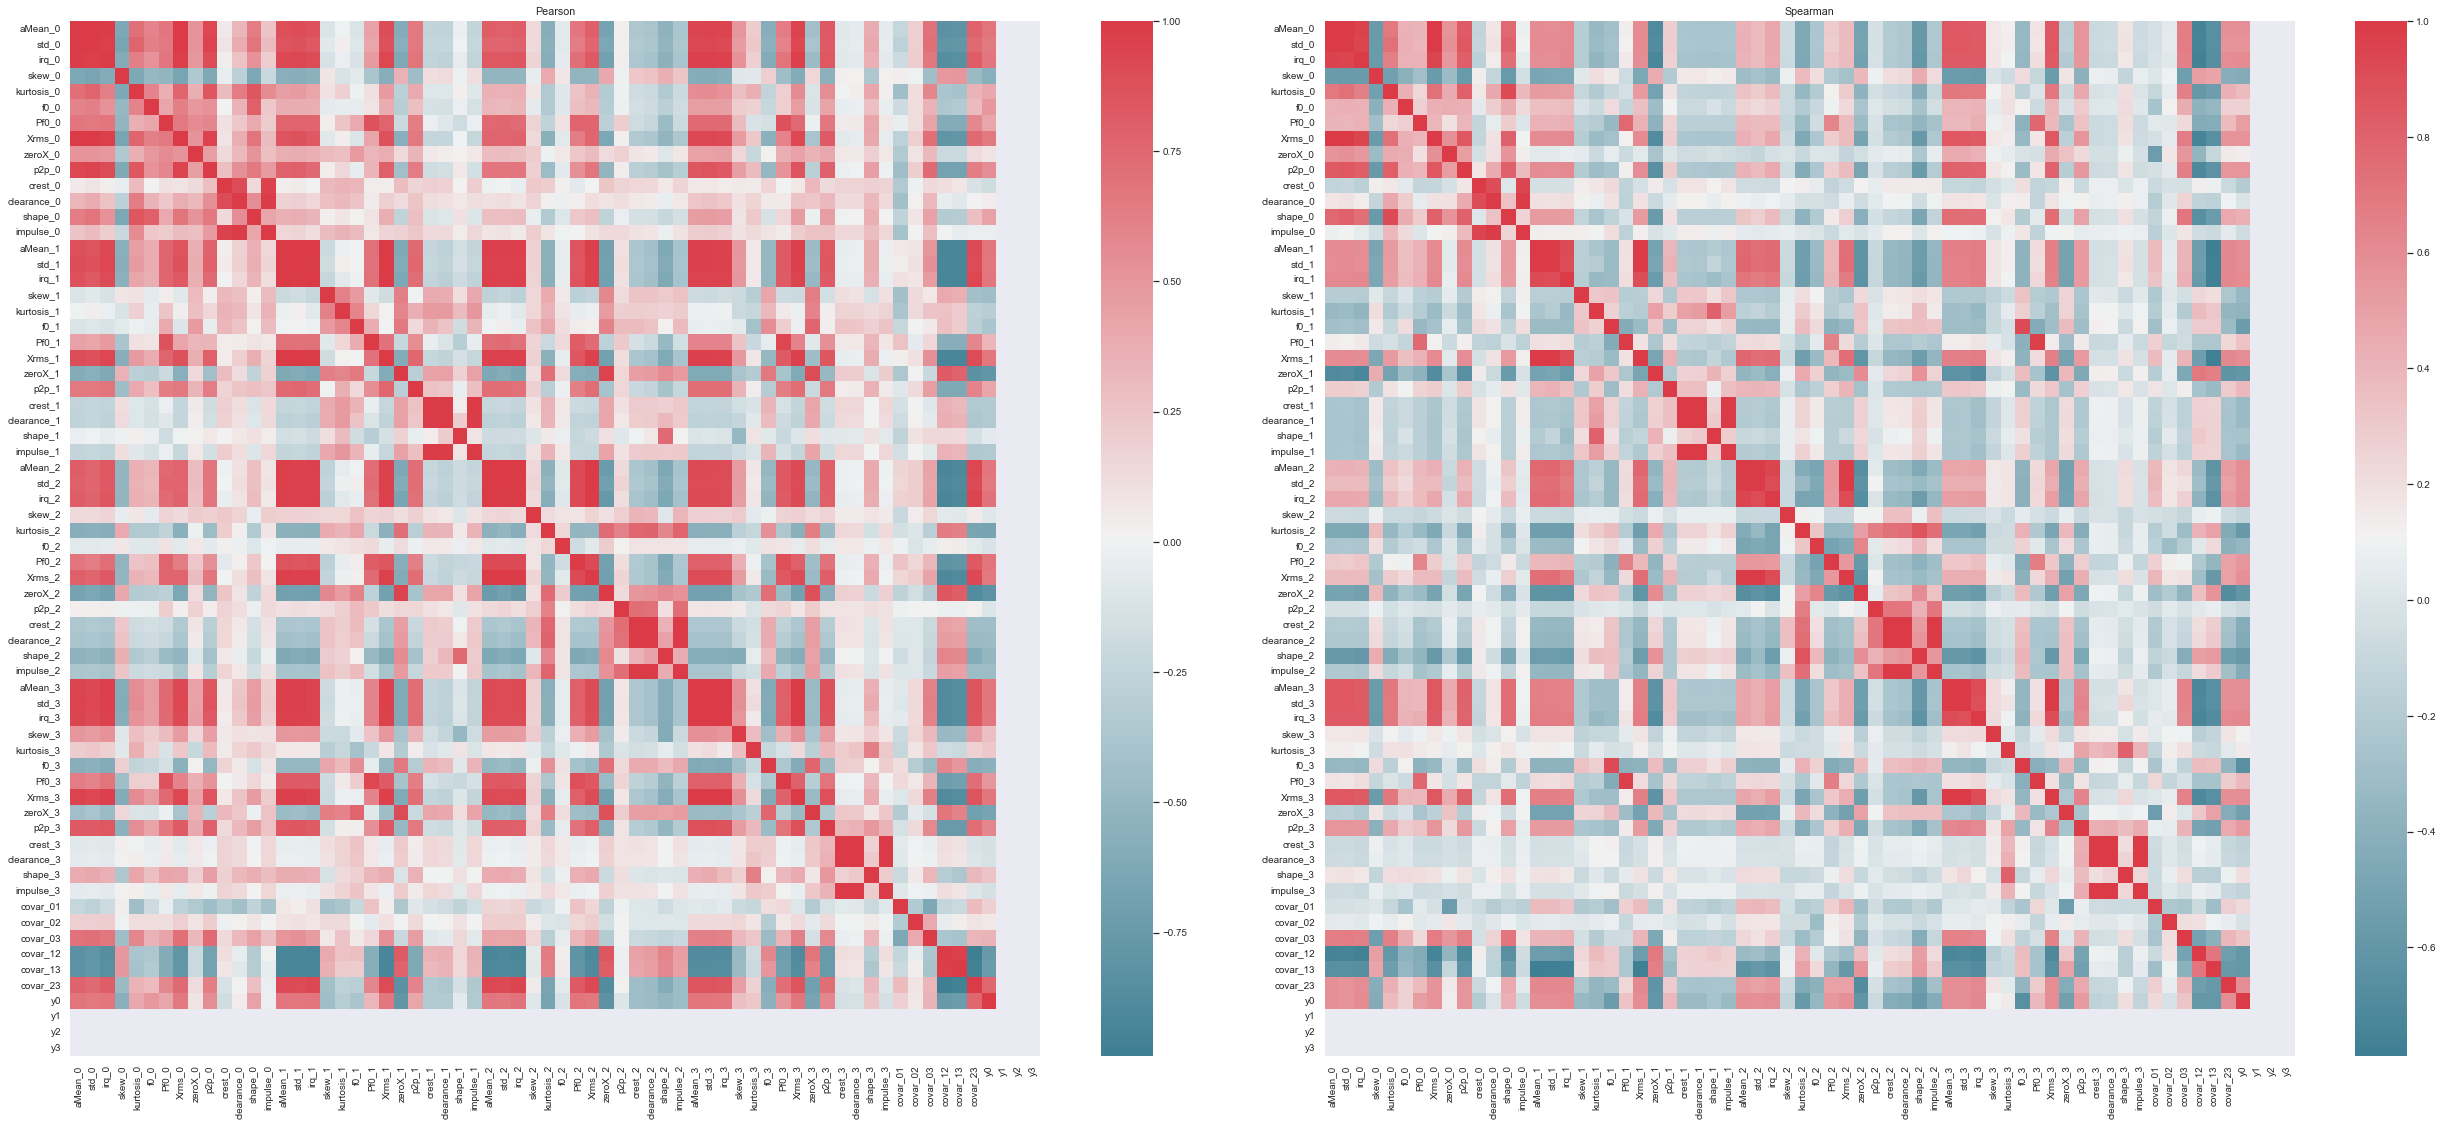

In [250]:
fig, axes = plt.subplots(1,2,figsize=(35,15), )
plt.tight_layout()

corr_pearson = df.corr(method='pearson')
axes[0].set_title("Pearson")
sns.heatmap(corr_pearson, cmap=sns.diverging_palette(220,10,as_cmap=True),fmt=".2f",ax=axes[0])
sns.set(font_scale=0.9)

corr_spearman = df.corr(method='spearman')
axes[1].set_title("Spearman")
sns.heatmap(corr_spearman, cmap=sns.diverging_palette(220,10,as_cmap=True),fmt=".2f")
sns.set(font_scale=0.9)

In [251]:
# Ahora, determinamos cuales features son candidatas a quitar según la correlación con otras features, para así reducir las dimensiones de nuestro dataset.
# Para eso, fijamos un threshold de 95% de correlación.
threshold = 0.8
corr_tril_pe = np.triu(corr_pearson, k=1)   # Keep the upper triangle for Pearson
corr_tril_sp = np.triu(corr_spearman, k=1)  # Keep the upper triangle for Spearman
indices_pe = np.where(abs(corr_tril_pe) >= threshold)
indices_sp = np.where(abs(corr_tril_sp) >= threshold)
# dims_to_del.update(indices_pe[1])  # Add the dimensions that correspond to a pearson coef greater than the threshold
print('Dims to delete for ' + str(threshold) + ' threshold: ')
pairs_pe = list(zip(df.columns[indices_pe[0]].tolist(), df.columns[indices_pe[1]].tolist()))
pairs_sp = list(zip(df.columns[indices_sp[0]].tolist(), df.columns[indices_sp[1]].tolist()))
print("\n Pearson: ", pairs_pe)
print("\n Spearman: ", pairs_sp)

Dims to delete for 0.8 threshold: 

 Pearson:  [('aMean_0', 'std_0'), ('aMean_0', 'irq_0'), ('aMean_0', 'Xrms_0'), ('aMean_0', 'p2p_0'), ('aMean_0', 'aMean_1'), ('aMean_0', 'std_1'), ('aMean_0', 'irq_1'), ('aMean_0', 'Xrms_1'), ('aMean_0', 'aMean_2'), ('aMean_0', 'irq_2'), ('aMean_0', 'aMean_3'), ('aMean_0', 'std_3'), ('aMean_0', 'irq_3'), ('aMean_0', 'Xrms_3'), ('aMean_0', 'p2p_3'), ('aMean_0', 'covar_12'), ('aMean_0', 'covar_13'), ('std_0', 'irq_0'), ('std_0', 'Xrms_0'), ('std_0', 'p2p_0'), ('std_0', 'aMean_1'), ('std_0', 'std_1'), ('std_0', 'irq_1'), ('std_0', 'Xrms_1'), ('std_0', 'aMean_3'), ('std_0', 'std_3'), ('std_0', 'irq_3'), ('std_0', 'Xrms_3'), ('std_0', 'p2p_3'), ('irq_0', 'Xrms_0'), ('irq_0', 'p2p_0'), ('irq_0', 'aMean_1'), ('irq_0', 'std_1'), ('irq_0', 'irq_1'), ('irq_0', 'Xrms_1'), ('irq_0', 'aMean_2'), ('irq_0', 'std_2'), ('irq_0', 'irq_2'), ('irq_0', 'Xrms_2'), ('irq_0', 'aMean_3'), ('irq_0', 'std_3'), ('irq_0', 'irq_3'), ('irq_0', 'Xrms_3'), ('irq_0', 'p2p_3'), ('irq_

In [252]:
temp = pairs_sp
for i in temp:  # for each item
    if(i[0][-1] != i[1][-1]):
        continue    # do not search for correlation between bearings

    if(i[0][-1] != '0' and i[1][-1] != '0'):
        print('done')
        break   # If passed over bearing 0, the you are done
    
    temp1 = i[0]
    temp2 = i[1]
    exists = 0
    for index in range(4):
        temp1 = temp1[:-1] + str(index)
        temp2 = temp2[:-1] + str(index)
        temp_tuple = (temp1, temp2)
        if(temp_tuple in temp):
            exists += 1
        else:
            break
    if(exists == 4):
        print((temp1[:-2], temp2[:-2]) ,'exists in all bearings!!')
        


('aMean', 'std') exists in all bearings!!
('aMean', 'irq') exists in all bearings!!
('aMean', 'Xrms') exists in all bearings!!
('std', 'irq') exists in all bearings!!
('std', 'Xrms') exists in all bearings!!
('irq', 'Xrms') exists in all bearings!!
('kurtosis', 'shape') exists in all bearings!!
('crest', 'clearance') exists in all bearings!!
('crest', 'impulse') exists in all bearings!!
('clearance', 'impulse') exists in all bearings!!
done


In [253]:
# Para la selección, se consideró que la correlación esté presente para los 4 rodamientos ya que no queremos introducir asimetría en el tratamiento de cada rodamiento.
# Tampoco se considera la correlación entre rodamientos, ya que los trataremos de forma cuasi-independiente.
# Además, se utilizó la correlación de Spearman, ya que, según vimos durante la exploración del dataset, un gran indicador de que un rodamiento se encuentra próximo a su 
# falla es cuando la variable comienza a aumentar o disminuir (respecto a su valor estacionario). Por lo tanto, si nuestro interes ahora es reducir las dimensiones, con buscar
# una relación monotónica entre dos features (Spearman) nos permite reducir una dimensión mientras que mantener la información de la falla.
# Podemos ver que las siguientes features están altamente correlacionadas:
# aMean <-> std <-> irq <-> Xrms
# kurtosis <-> shape
# crest <-> clearance <-> impulse
# Para determinar cual feature eliminar, miramos la correlación de cada una con la variable objetivo:

features_to_del = ['aMean', 'std', 'irq', 'Xrms', 'kurtosis', 'shape', 'crest', 'clearance', 'impulse']
dims_to_del_id = []
for j in range(4):
    dims_to_del_id.append([(single_features[i]+cols_per_bearing*j) for i in features_to_del])
temp = zip(dims_to_del_id[0], dims_to_del_id[1], dims_to_del_id[2], dims_to_del_id[3])
temp = list(temp)
for i in temp:
    corr_to_output = corr_spearman['y'+str(rodamiento_que_fallo-1)][df.columns[list(i)].to_list()]
    print('Correlación promedio de', df.columns[list(i)].to_list()[0][:-2], 'con la salida =', corr_to_output.mean())


Correlación promedio de aMean con la salida = 0.5866801131793136
Correlación promedio de std con la salida = 0.5828564475163407
Correlación promedio de irq con la salida = 0.6036384761950203
Correlación promedio de Xrms con la salida = 0.5827881226748846
Correlación promedio de kurtosis con la salida = -0.10765717518793931
Correlación promedio de shape con la salida = -0.052769552551397376
Correlación promedio de crest con la salida = -0.273410710011182
Correlación promedio de clearance con la salida = -0.22555801549495294
Correlación promedio de impulse con la salida = -0.2405388696216624


In [254]:
# A partir del resultado anterior, borraremos las siguientes features:
features_to_del = [ 'aMean', 'std', 'Xrms', 'shape', 'clearance', 'impulse']

dims_to_del_id = []
for j in range(4):
    dims_to_del_id.append([(single_features[i]+cols_per_bearing*j) for i in features_to_del])
dims_to_del_id = np.array(dims_to_del_id).flatten()
dims_to_del_name = df.columns[dims_to_del_id].to_list()
print("Se borrarán las siguientes features: \n", dims_to_del_name)

Se borrarán las siguientes features: 
 ['aMean_0', 'std_0', 'Xrms_0', 'shape_0', 'clearance_0', 'impulse_0', 'aMean_1', 'std_1', 'Xrms_1', 'shape_1', 'clearance_1', 'impulse_1', 'aMean_2', 'std_2', 'Xrms_2', 'shape_2', 'clearance_2', 'impulse_2', 'aMean_3', 'std_3', 'Xrms_3', 'shape_3', 'clearance_3', 'impulse_3']


In [255]:
# Drop highly correlated features
df_red = df.drop(dims_to_del_name, axis=1)
df_red.describe()
# for i in range(4):
#     df_red = df_red.drop(['aMean_'+str(i)], axis=1)
#     df_red = df_red.drop(['std_'+str(i)], axis=1)


,irq_0,skew_0,kurtosis_0,f0_0,Pf0_0,zeroX_0,p2p_0,crest_0,irq_1,skew_1,...,covar_01,covar_02,covar_03,covar_12,covar_13,covar_23,y0,y1,y2,y3
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,9.840000e+02,9.840000e+02,984.000000,984.0,984.0,984.0
mean,0.128091,-0.033123,0.827138,1488.989853,52.411202,6879.347561,1.054736,4.938415,0.132087,0.107973,...,0.001577,-0.000474,-0.000045,-0.001310,-1.368870e-03,7.654559e-04,0.146341,0.0,0.0,0.0
std,0.058001,0.089029,0.965787,1202.293360,2.529818,442.081350,0.740102,0.599819,0.020335,0.050779,...,0.001227,0.000621,0.001092,0.002179,1.020015e-03,1.083733e-03,0.353628,0.0,0.0,0.0
min,0.000000,-0.766067,-1.609774,58.593750,15.223287,0.000000,0.005000,1.304860,0.002000,-0.289639,...,-0.016802,-0.006265,-0.003449,-0.017709,-9.969288e-03,5.918902e-07,0.000000,0.0,0.0,0.0
25%,0.100000,-0.047506,0.393747,985.351562,51.522408,6649.750000,0.752000,4.575072,0.125000,0.095776,...,0.001407,-0.000580,-0.000314,-0.001028,-1.180721e-03,3.675887e-04,0.000000,0.0,0.0,0.0
50%,0.103000,-0.009859,0.484787,985.351562,52.352332,6759.500000,0.830000,4.889787,0.127000,0.114054,...,0.001508,-0.000503,-0.000262,-0.000590,-1.048524e-03,4.074848e-04,0.000000,0.0,0.0,0.0
75%,0.131000,0.013705,0.878688,985.351562,52.871842,7161.000000,1.101750,5.222041,0.129000,0.132009,...,0.001630,-0.000414,-0.000092,-0.000482,-9.966261e-04,5.216813e-04,0.000000,0.0,0.0,0.0
max,0.630000,0.579698,14.110009,4849.609375,65.182241,8870.000000,9.998000,8.663341,0.266000,0.642007,...,0.010003,0.010375,0.019175,0.000025,6.124187e-07,8.906680e-03,1.000000,0.0,0.0,0.0


In [256]:
df_red.to_csv(PATH_CSV_REDUCED, index=False)